In [ ]:
# !wget https://storage.yandexcloud.net/datasouls-ods/materials/87f47580/train_data.zip
# !unzip './train_data.zip'

In [ ]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
!pip install tensorflow==2.1.0

In [ ]:
# !python -m pip install 'git+https://github.com/xiaohu2015/SwinT_detectron2.git'
# !git clone https://github.com/xiaohu2015/SwinT_detectron2.git

In [ ]:
import cv2
import random
import json
import os
import warnings
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil
import tqdm
from matplotlib import pyplot as plt
import numpy as np
import logging

import torch, torchvision
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog,DatasetCatalog
from detectron2.data.datasets import register_coco_instances,load_coco_json
from detectron2.data import detection_utils as utils
from detectron2.engine import DefaultTrainer
from detectron2.engine import HookBase
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
import copy

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

logger = logging.getLogger('detectron2')
logger.setLevel(logging.CRITICAL)

In [ ]:
PATH = 'train_segmentation/'

In [ ]:
with open(PATH + 'annotations.json') as f:
    annotations = json.load(f)

In [ ]:
annotations.keys()

dict_keys(['categories', 'images', 'annotations'])

In [ ]:
annotations_val = {}
annotations_val['categories'] = annotations['categories']

annotations_train = {}
annotations_train['categories'] = annotations['categories']

annotations_val['images'] = []
annotations_train['images'] = []
for num, img in enumerate(annotations['images']):
    if num % 10 == 1:
        annotations_val['images'].append(img)
    else:
        annotations_train['images'].append(img)

val_img_id = [i['id'] for i in annotations_val['images']]
train_img_id = [i['id'] for i in annotations_train['images']]

annotations_val['annotations'] = []
annotations_train['annotations'] = []

for annot in annotations['annotations']:
    if annot['image_id'] in val_img_id:
        annotations_val['annotations'].append(annot)
    elif annot['image_id'] in train_img_id:
        annotations_train['annotations'].append(annot)
    else:
        print('Аннотации нет ни в одном наборе')

In [ ]:
with open(PATH + 'annotations_val.json', 'w') as outfile:
    json.dump(annotations_val, outfile)    
    
with open(PATH + 'annotations_train.json', 'w') as outfile:
    json.dump(annotations_train, outfile)

In [ ]:
for d in ['train','val']:
    DatasetCatalog.register("my_dataset_" + d, lambda d = d: load_coco_json("./train_segmentation/annotations_{}.json".format(d),
    image_root= "./train_segmentation/images", \
    dataset_name="my_dataset_" + d, extra_annotation_keys=['bbox_mode']))

In [ ]:
dataset_dicts_train = DatasetCatalog.get("my_dataset_train")
train_metadata = MetadataCatalog.get("my_dataset_train")

In [ ]:
dataset_dicts_val = DatasetCatalog.get("my_dataset_val")
val_metadata = MetadataCatalog.get("my_dataset_val")

In [ ]:
print('Размер обучающей выборки (Картинки): {}'.format(len(dataset_dicts_train)))
print('Размер тестовой выборки (Картинки): {}'.format(len(dataset_dicts_val)))

Размер обучающей выборки (Картинки): 838
Размер тестовой выборки (Картинки): 94


In [ ]:
import os
from IPython.display import Image

@interact
def show_images(file=range(len(dataset_dicts_val))):
    example = dataset_dicts_val[file]
    image = utils.read_image(example["file_name"], format="RGB")
    plt.figure(figsize=(3,3),dpi=200)
    visualizer = Visualizer(image[:, :, ::-1], metadata=val_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(example)
    plt.imshow(vis.get_image()[:, :,::-1])
    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("Misc/mask_rcnn_R_50_FPN_3x_gn.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/mask_rcnn_R_50_FPN_3x_gn.yaml")

In [ ]:
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.INPUT.RANDOM_FLIP = "horizontal"

cfg.INPUT.MIN_SIZE_TRAIN = 512
cfg.INPUT.MAX_SIZE_TRAIN = 768

cfg.INPUT.MIN_SIZE_TEST = 512
cfg.INPUT.MAX_SIZE_TEST = 768

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

cfg.INPUT.FORMAT = 'BGR' 

cfg.DATALOADER.NUM_WORKERS = 4

cfg.SOLVER.IMS_PER_BATCH = 1

cfg.SOLVER.BASE_LR = 0.04

cfg.SOLVER.GAMMA = 0.1

cfg.SOLVER.MAX_ITER = 50 * 932 // 1

cfg.SOLVER.STEPS = (500, 1000) 

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

cfg.SOLVER.CHECKPOINT_PERIOD = 750

cfg.OUTPUT_DIR = './output'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
            T.Resize((1024, 768)),
#             T.RandomBrightness(0.8, 1.8),
#             T.RandomContrast(0.6, 1.3),
#             T.RandomSaturation(0.8, 1.4),
            T.RandomRotation(angle=[90, 90]),
            T.RandomFlip(prob=0.6, horizontal=True, vertical=False),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    
    return dataset_dict

from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [ ]:
trainer = CustomTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

In [ ]:
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[03/03 19:12:53 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(
      256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_output2): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_lateral3): Conv2d(
      512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_output3): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_lateral4): Conv2d(
      1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
      (norm): GroupNorm(32, 256, eps=1e-05, affine=True)
    )
    (fpn_output4): Conv2d(
      256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
      (norm): Group

In [ ]:
cfg.MODEL.WEIGHTS = "./output/model_final.pth"

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = ("my_dataset_val", )

cfg.INPUT.MIN_SIZE_TEST= 512
cfg.INPUT.MAX_SIZE_TEST = 768
cfg.INPUT.FORMAT = 'BGR'

cfg.TEST.DETECTIONS_PER_IMAGE = 1000

predictor = DefaultPredictor(cfg)

In [ ]:
@interact
def show_images(file=range(len(dataset_dicts_val))):
    print(file)
    example = dataset_dicts_val[file]
    im = cv2.imread(example["file_name"])
    outputs = predictor(im)
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(4,4),dpi=200)
    
    v = Visualizer(im[:, :],
                  metadata=val_metadata, 
                  scale=0.4 )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    axs[0].imshow(im[:, :, ::-1])
    axs[1].imshow(v.get_image()[:, :, ::-1])
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].set_title('Original')
    axs[1].set_title('Predict')

    plt.show()

interactive(children=(Dropdown(description='file', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

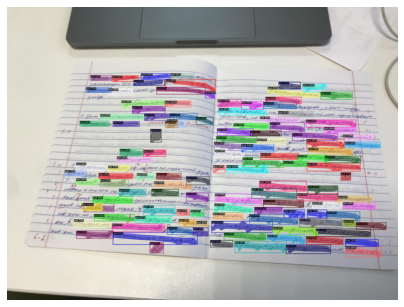

In [ ]:
id_image_selected = 2
example = dataset_dicts_val[id_image_selected]
im = cv2.imread(example["file_name"])
outputs = predictor(im)
plt.figure(figsize=(7,7))
v = Visualizer(im[:, :],
              metadata=val_metadata, 
              scale=0.4 )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1])
plt.axis('off')
plt.show()

In [ ]:
with open('train_segmentation/annotations_val.json') as f:
    annotations_val = json.load(f)

In [ ]:
val_images = annotations_val['images']
val_predictions = {}

In [ ]:
for val_img in tqdm.tqdm_notebook(val_images):
    file_name = val_img['file_name']
    img_path = os.path.join('train_segmentation/images/',file_name)
    im = cv2.imread(img_path)
    outputs = predictor(im)
    prediction = outputs['instances'].pred_masks.cpu().numpy()
    mask = np.add.reduce(prediction)
    mask = mask > 0
    val_predictions[file_name] = mask

  0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
np.savez_compressed('val_pred.npz',**val_predictions)

In [ ]:
loaded_train = np.load('train_segmentation/binary.npz')

In [ ]:
loaded_val_pred = np.load('val_pred.npz')

In [ ]:
def f1_loss(y_true, y_pred):      
    tp = np.sum(y_true & y_pred)
    tn = np.sum(~y_true & ~y_pred)
    fp = np.sum(~y_true & y_pred)
    fn = np.sum(y_true & ~y_pred)
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    
    f1 = 2* precision*recall / ( precision + recall + epsilon)

    return f1 

f1_scores = []
for key in tqdm.tqdm_notebook(loaded_val_pred.files):
    pred = loaded_val_pred[key].reshape(-1)
    true = loaded_train[key].reshape(-1)
    
    f1_img = f1_loss(true,pred)
    f1_scores.append(f1_img)

  0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
np.mean(f1_scores)

0.8346454422892752

In [ ]:
from IPython.display import FileLink
FileLink(r'./output/model_final.pth')

/home/jovyan/output/model_final.pth